In [1]:
%pylab inline
import pylab as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import geopandas as gp
from datetime import datetime

from code.main import getSettings, data_preload
from code.misc.logger import getLogger
from code.misc import getRegScore

In [3]:
from code.iteration import iteration, iterate

In [4]:
idx = pd.IndexSlice

# LOAD DATA

In [5]:
settings = getSettings()

In [6]:
start = datetime.now()  # start of the calculations

logger = getLogger()
settings['limit'] = None
settings['logger'] = logger
result_path = datetime.now().strftime(start.strftime(settings['results']))

In [7]:
poi, buff, reg = data_preload(settings, logger)

## Check Visually

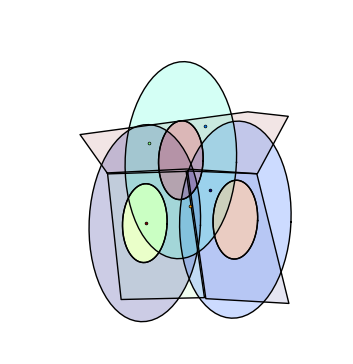

In [8]:
ax = reg.plot(alpha=.1)
buff.plot(alpha=.2, ax=ax)
poi.plot(ax=ax)

plt.axis('off');

# Check Poi Calculation

In [ ]:
from code.misc import getPoiScore, adjustScore, getPOI

### Check Buffer coefficients

In [ ]:
poi_test = poi.copy()
poi_test['type'] = pd.Series(['foot']*3 + ['stepless']*2)

In [ ]:
result = adjustScore(poi_test, settings)

In [ ]:
assert (result['score'] == pd.Series([320.0, 640.0, 80.0, 1500.0, 1000.0])).all()

## Check spatial grouping

In [ ]:
x = getPOI(buff, poi, settings)

In [ ]:
assert len(x)==10

In [ ]:
x = adjustScore(x, settings)

In [ ]:
result_score = x.groupby('office_id').agg({'score': 'sum'})
print result_score

In [ ]:
from pandas.util.testing import isiterable


In [ ]:
def get_pois(pois):
    '''gets two types of pois, 
    depending of "aquisition" buffer'''
    stepless_poi = pois[pois['type']=='stepless'].groupby('office_id').agg({'pid': lambda x: list(x)}).unstack()
    foot_poi = pois[pois['type']=='foot'].groupby('office_id').agg({'pid': lambda x: list(x)}).unstack()

    pois = pd.DataFrame({'stepless_poi':stepless_poi,
                 'foot_poi': foot_poi})
    pois.index = pois.index.get_level_values(1)
    return pois

In [ ]:
pois = get_pois(x)
pois

In [ ]:
pois

## Check overal function

In [ ]:
poi_score, pois = getPoiScore(buff, poi, settings)

In [ ]:
poi_score

In [ ]:
pois

# Check region calculations

## Check spatial part

In [ ]:
results = []
for n, g in buff.reset_index().groupby('office_id'):
    r = gp.overlay(g, reg, how='intersection')
    results.append(r)
    
my_result = gp.GeoDataFrame(pd.concat(results))[['type','geometry','disabled', 'reg_area','office_id']]

In [ ]:
my_result.shape

In [ ]:
my_result.plot()

In [ ]:
my_result[my_result['office_id']==3].plot()

In [ ]:
my_result

In [ ]:
my_result[my_result['office_id']==1].shape

In [ ]:
my_result['disabled'] * (my_result.area / my_result['reg_area'])

## Check calculations

In [ ]:
g = getRegScore(buff, reg, settings)

In [ ]:
g

## Check Data update

In [ ]:
buff[buff.index.get_level_values(1) != 2]

In [ ]:
buff.loc[idx['foot',:],'geometry']

In [ ]:
bid = 1

slctd_foot = buff.loc[idx['foot', bid], 'geometry']
slctd_step = buff.loc[idx['stepless', bid], 'geometry']
buff = buff[buff.index.get_level_values(1) != bid]

In [ ]:
fs = buff.loc[idx['stepless', :], :].copy()
fs.loc[:, 'geometry'] = fs.loc[:, 'geometry'].intersection(slctd_foot)

In [ ]:
fs.plot()

In [ ]:
def get_fc(buff, slctd_step):
        fs = buff.loc[idx['stepless', :], :].copy()
        fs.loc[:, 'geometry'] = fs.loc[:, 'geometry'].intersection(slctd_step)
        fs.index = pd.MultiIndex.from_tuples([('foot_to_step', i) for _ , i in fs.index.tolist()])
        fs = fs[~fs['geometry'].is_empty]

        return pd.concat([buff, fs])

In [ ]:
get_fc(buff, slctd_foot).plot()

In [ ]:
def get_fc(buff, slctd_foot):
        '''adds a third type of buffer
        one where foot distance is already covered,
        but stepless is not. pois and regions here
        will add a score=difference between foot and stepless

        Args:
            buff: current buffs
            slctd_step: stepless buffer for selected office
        Returns:
            buff: buff with new buffers adder
        '''
        fs = buff.loc[idx['stepless', :], :].copy()
        
        fs.loc[:, 'geometry'] = fs.loc[:, 'geometry'].intersection(slctd_foot)
        fs.index = pd.MultiIndex.from_tuples([('foot_to_step', i) for _, i in fs.index.tolist()])
        fs = fs[~fs['geometry'].is_empty]

        return pd.concat([buff, fs]).sort_index()


def update_buff(buff, bid):
        '''update buff by removing
        and substracting
        buffers for chosen office

        Args:
            buff: buffers
            bid(int): id of chosen office
        '''
        
        slctd_foot = buff.loc[idx['foot', bid], 'geometry']
        slctd_step = buff.loc[idx['stepless', bid], 'geometry']
        buff = buff[buff.index.get_level_values(1) != bid]

        # normal reduction
        buff.loc[idx['foot', :], 'geometry'] = buff.loc[
            idx['foot', :], 'geometry'].difference(slctd_foot)
        buff.loc[idx['foot', :], 'geometry'] = buff.loc[
            idx['foot', :], 'geometry'].difference(slctd_step)
        buff.loc[idx['stepless', :], 'geometry'] = buff.loc[
            idx['stepless', :], 'geometry'].difference(slctd_step)
        
        if 'foot_to_step' in buff.index.get_level_values(0):
            buff.loc[idx['foot_to_step', :], 'geometry'] = buff.loc[
                idx['foot_to_step', :], 'geometry'].difference(slctd_step)

        buff = buff[~buff['geometry'].is_empty]
        buff2 = get_fc(buff, slctd_foot)

        return buff2

In [ ]:
poi, buff, reg = data_preload(settings, logger)

In [ ]:
buff2 = update_buff(buff,1)
buff2.plot()

In [ ]:
buff2

In [ ]:
update_buff(buff2, 2).plot()

## Check Preparation

In [ ]:
poi[poi.intersects(buff.unary_union)]

In [ ]:
def prepare(buff, poi, reg, settings):
    '''optimize geometry for the iteration'''

    n_pois = len(poi)
    poi = poi[poi.intersects(buff.unary_union)]
    settings['logger'].info(
        'Dropped {} pois, as they are out of borders'.format(len(poi) - n_pois))

    return buff, poi, reg

In [ ]:
buff, poi, reg = prepare(buff, poi, reg, settings)

# CHeck overal iteration

In [ ]:
?iteration

In [ ]:
bid, score, reg_score, foot_pois, stepless_pois = iteration(1, buff, poi, reg, settings)

In [ ]:
stepless_pois

## RUN WHOLE THING

In [13]:
poi, buff, reg = data_preload(settings, logger)

In [8]:
iterate(buff, poi, reg, 'test_results.txt', settings)

/Users/philippk/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
